# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy\
matplotlib\
nest_asyncio\
jsonpath-ng\
ruamel.yaml\
cwl_utils
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops
from datetime import datetime
import igraph              
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work
import glob
import pandas as pd
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src')))

import WFQC.data
from WFQC.network import create_citation_network 
from WFQC.workflow import parse_workflows, radnomise_workflows
from WFQC.metrics import sum_metric, path_metric

Check that the packages are installed and functional 

In [2]:
print("igraph version:", igraph.__version__) #TODO: sometimes this runs forever when it does not find cytoscape, sometimes not. check why
try: 
    dir(p4c)
    p4c.cytoscape_ping()    
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")

igraph version: 0.11.5
Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!


In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


## Downloading data 

Looking at the documentatio of the imported functions to see everythign is working as intended 

In [3]:
help(WFQC.data)

Help on module WFQC.data in WFQC:

NAME
    WFQC.data - Functions to download data.

FUNCTIONS
    async aggregate_requests(session, url)
        Sync the bio.tools (page) requests so they are all made in a single session 
        
        Parameters
        ----------
        session : aiohttp.client.ClientSession object
            session object for package aiohttp
        url : str
            url for request
    
    europepmc(article_id, format='JSON', source='MED', page=1, page_size=1000)
        Downloads pmids for the articles citing the given article_id, returns list of citation pmids (PubMed IDs)
            
        Parameters
        ----------
        article_id : str # TODO: int? 
            pmid, PubMed ID, for a given article.
        source: str
            source ID as given by the EuropePMC API documentation: https://europepmc.org/Help#contentsources 
        
        page, int, default == 1
            determines where to start looking TODO: remove this, why would

## Graph generation

In [4]:
topicID = "topic_0121" # proteomics, which is also the default

### Load data

In [34]:
#TODO: filepath for input files! - change bio.tools thing 

path_to_data = 'data/out_cocitation'

G, included_tools = create_citation_network(inpath=path_to_data) # TODO: if no data then make data or ask if make data?


Loading saved data.


### Generate new graph


#### Test size

For example with a testsize of 10 tools

In [ ]:
G, included_tools = create_citation_network(loadData=False, testSize=20) 

Or with the citation nodes included

In [ ]:
G, included_tools = create_citation_network(loadData=False, testSize=20, includeCitationNodes=True) 

Bio.tools data loaded from existing CSV file.
Creating test-cocitation network of size 20. Random seed is 42.


Processing PMIDs: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

Creating citation graph using igraph.
1024 unique out of 1024 edges total!
Removing citations with degree less or equal to 1 (Non co-citations).
Number of vertices removed with threshold 20: 0
Saving data to directory out_202405241511.


#### Full network

Or the entire bio.tools database proteomics topic (default), or another specified topic:

In [ ]:
G, included_tools = create_citation_network(loadData=False, topicID = topicID) #again

Lets check what attributes the co-citation graph has, and that the it was correctly generated

In [46]:
graph_attributes = G.vs.attributes()
print("Graph-level attributes:", graph_attributes)

edge_attributes = G.es.attributes()
print("Edge-level attributes:", edge_attributes)


print('Tools in graph: ', len(included_tools))

if len(np.sort(G.vs['name'])) != len(np.sort(included_tools)):
    print(len(np.sort(G.vs['name'])), len(np.sort(included_tools)))
    diff=set(included_tools) -set(included_tools).intersection(set(G.vs['name']))
    print(diff) # TODO: its still endign up here wtf fix it

    # for now
    included_tools.remove(list(diff)[0])
    print(len(np.sort(G.vs['name'])), len(np.sort(included_tools)))

Graph-level attributes: ['name']
Edge-level attributes: ['weight']
Tools in graph:  1103


## The metric

### Download workflow data


Load the latest bio.tools file

In [5]:
date_format = "%Y%m%d"
pattern = f'biotools_metadata_{topicID}*'
matching_files = glob.glob(pattern)

if matching_files:
    matching_files.sort(key=os.path.getmtime)
    cvsfile = matching_files[-1] # get the latest file
    print(f"Bio.tools data loaded from existing CSV file {cvsfile}.")


Bio.tools data loaded from existing CSV file biotools_metadata_topic_0121_20240523.csv.


Test that loading one workflow works

In [11]:
cwl_file = "./workflows/APE/candidate_workflow_2.cwl" # loading one of the APE generated workflows 

workflow_pairs, workflow_tools = parse_workflows(cwl_file,cvsfile) # TODO: more than one at a time? 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, len(workflow_pairs)) # TODO: could improve the rand wf method to have the same shape as the og nw by 
                                                                                                    # adding 

print(workflow_pairs, rand_workflow_pairs)


[('14632076', '12403597'), ('23051804', '23148064'), ('29400476', '23051804'), ('29400476', '14632076')] [('35803561', '24437954'), ('36781298', '25346941'), ('20929869', '36781298'), ('33196814', '35021191')]


could add visualisation of the workflows and the original workflows. 

### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

Test that calculating the metric for one workflow works

This is for if you are using the CITATION graph that includes the citation nodes:

In [12]:
# For one workflow
citation = False
if citation:
    metric_score, raw_results = sum_metric_citation(G, workflow_pairs)

    print(raw_results)

    print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


This is for CO-CITATION graphs:

In [13]:
# For one workflow
from WFQC.metrics import sum_metric

metric_score, raw_results = sum_metric(G, workflow_pairs, included_tools)

print(raw_results)

print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[0.20408163265306123, 1.8867924528301887, 14.38679245283019, 13.361976369495165]
Total cocitation score for workflow [('14632076', '12403597'), ('23051804', '23148064'), ('29400476', '23051804'), ('29400476', '14632076')] is 7.459910726952151.


### Evaluate results 

OBS: This section continues with the co-citation graph in mind

These are the tools included in workflomics, but we will not use them right now

In [14]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have pmid info

In [25]:
workflows = []
rand_workflows = []

#TODO: make this a function?
#TODO. verify all the functions involved in this using some mock nw or sth

pattern = f'workflows/APE/candidate_workflow_*'
matching_files = glob.glob(pattern)
#nr_files = len(matching_files)

# Right now as the name generation is wrong: 

sorted_match = np.sort([int(path.split("_")[-1].strip(".cwl")) for path in matching_files])
nr_files = sorted_match[-1]


for i in range(1, nr_files+1):

    if '8' in str(i) or '9' in str(i):
        i += 1
        continue


    cwl_file = f"workflows/APE/candidate_workflow_{i}.cwl"
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file, cvsfile) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflows(included_tools, num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        print("no", cwl_file)
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

no workflows/APE/candidate_workflow_6.cwl
no workflows/APE/candidate_workflow_16.cwl
no workflows/APE/candidate_workflow_20.cwl
no workflows/APE/candidate_workflow_21.cwl
no workflows/APE/candidate_workflow_23.cwl
no workflows/APE/candidate_workflow_24.cwl
no workflows/APE/candidate_workflow_25.cwl
no workflows/APE/candidate_workflow_26.cwl
no workflows/APE/candidate_workflow_27.cwl
no workflows/APE/candidate_workflow_30.cwl
no workflows/APE/candidate_workflow_33.cwl
no workflows/APE/candidate_workflow_71.cwl
no workflows/APE/candidate_workflow_72.cwl
no workflows/APE/candidate_workflow_73.cwl
no workflows/APE/candidate_workflow_74.cwl
no workflows/APE/candidate_workflow_75.cwl
no workflows/APE/candidate_workflow_76.cwl
no workflows/APE/candidate_workflow_100.cwl
no workflows/APE/candidate_workflow_104.cwl
no workflows/APE/candidate_workflow_105.cwl
no workflows/APE/candidate_workflow_107.cwl
no workflows/APE/candidate_workflow_112.cwl
no workflows/APE/candidate_workflow_113.cwl
no wor

The workflows may contain tools that are not in our bio.tools file (they dont have pmids), so let's check how many we got:

In [28]:
print(len(workflows), " out of ", nr_files)

652  out of  1750


In [47]:
import pickle
savewf = True
if savewf:
    with open('./wfedges.pkl', 'wb') as f:
        pickle.dump(workflows, f)
    with open('./rndwfedges.pkl', 'wb') as f:
        pickle.dump(rand_workflows, f)


In [48]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = sum_metric(G, workflows[i], included_tools)
    rand_metric_score, rand_raw_results = sum_metric(G, rand_workflows[i], included_tools)

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    

/tmp/ipykernel_105411/2068821547.py:20: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:534
  results = G.get_shortest_paths(source, to=target, weights=G.es["weight"], output="epath")


This is the shortest path measurement, so the lower the metric score the "better"

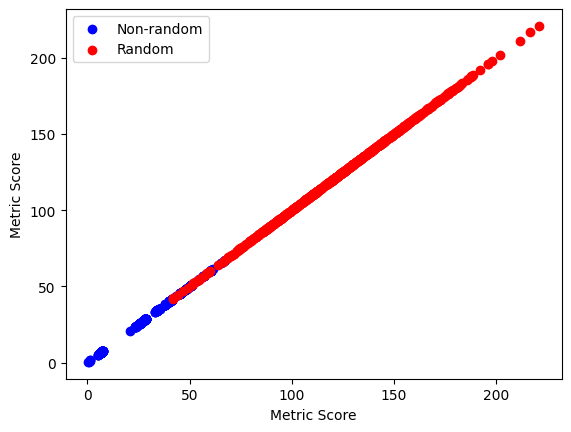

In [50]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.legend()
plt.show()


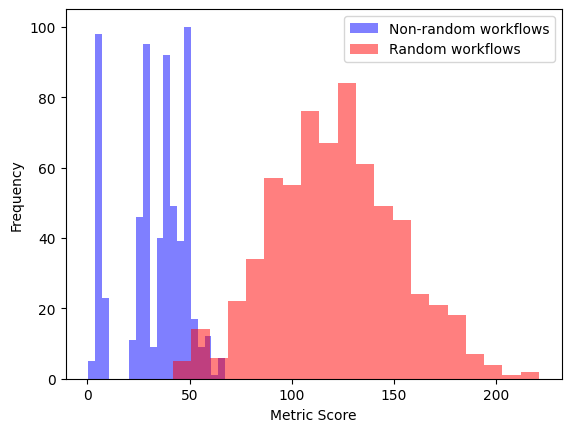

In [55]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random workflows')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random workflows')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()


# Show plot
plt.show()


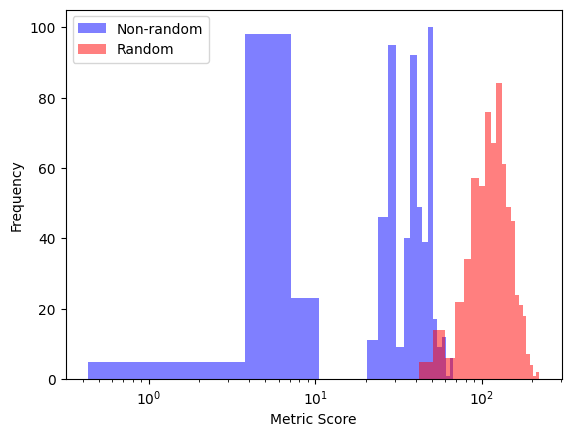

In [54]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # focus on blue dist

# Show plot
plt.show()


Obviously this comparison is not very fair and we should make sure that the "functional workflows" are drawn from the same set as the randoms, whereas now they are drawn from a very small subset of very well annotated tools. This is more to show that the comparison works, not that the results are reliable. 

## Visualisation


Using cytoscape to visualise the network

In [9]:

current_time = datetime.now().strftime("%Y%m%d%H%M")

p4c.create_network_from_igraph(G, f"Cocitations_Size{len(included_tools)}_{current_time}", collection="Citation networks")

# edge_attributes = p4c.get_table_columns(table='edge', columns=['weight'])
# weights = edge_attributes['weight']

Applying default style...
Applying preferred layout


346802

In [ ]:
print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

In [ ]:
# Styling edges
p4c.set_edge_label_mapping('weight')
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('weight', mapping_type='c'))